Sta 663 - Statistical Computing and Computation - Midterm 1
-----------
Due Monday, February 28th by 5:00 pm.

## Setup

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
# Load data
d1 = pd.read_csv("data/d1.csv")
d2 = pd.read_csv("data/d2.csv")
d3 = pd.read_csv("data/d3.csv")

In [3]:
# Helper functions

# Calculate xi-xj distance matrix
def distance_func(d, d2):
    # Create matrix of zeros
    xi_xj = np.zeros((len(d.x), len(d2.x)))
    
    n = len(d.x)
    m = len(d2.x)
    
    # Fill matrix with distance in x values
    for i in range(n): 
        for j in range(m):
            xi_xj[i, j] = d.x[i]-d2.x[j]
        
    return(xi_xj)    

# Calculate covariance matrix
def covariance_func(sig2n, sig2s, l, D):
    # Create matrix of zeros
    sig2n_matrix = np.zeros((D.shape[0], D.shape[1])) 
    
    # Fill diagonal with sig2n value
    np.fill_diagonal(sig2n_matrix, sig2n)
    
    #Calculate covariance matrix
    cov_matrix = sig2n_matrix + sig2s * np.exp(-(D)**2/(2*l))
    
    return(cov_matrix)

# Calculate log-likelihood 
def loglik_func(cov, d):
    u = np.zeros((d.shape[0], 1))
    y = np.array([d.y]).T
    y_u = y - u
    n = d.shape[0]
    
    # Calculate log-likelihood
    loglik =  -.5*(n*np.log(2*np.pi) + np.log(np.linalg.det(cov)) + 
                (y_u.T @ np.linalg.inv(cov) @ y_u))
    
    return(loglik)
                           

## Task 1 - Model fitting

I began the Model fitting process by first building a series of helper functions. The first function I built was the `distance_func` which takes two data frames as inputs and creates a distance matrix for each of the corresponding x values. Next I wrote the `covariance_func` that takes $\sigma^2_n$, $\sigma^2_s$, and _l_, as well as the output from the `distance_func`. Using these inputs the `covariance_func` outputs a covariance matrix. Next, I wrote a function for for calculating the log-likelihood, `loglik_func`. The `loglik_func` takes the covariance matrix, and a the data frame, and with these outputs the log-likelihood of the Gaussian process. Finally, I wrote the `fit` function and `objective_func` within the `fit` function. The `fit` function takes, five parameters, with which it calculates the distance matrix, uses the `objective_func` to output the negative log-likelihood, and finally optimizes the `objective_func`, returning the best parameters out of the n_init iterations.

In [4]:
def fit(d, n_init, seed, lb = [.1, 1e-6, 1e-6], ub = [.1, 5,2]):
        np.random.seed(seed)
        
        # Calculate distance matrix
        D = distance_func(d, d)
        
        # Set the bounds
        bounds = optimize.Bounds(lb, ub)
        
        # Return negative log-likelihood 
        def objective_func(theta):
            sig2n = theta[0]
            sig2s = theta[1]
            l = theta[2]
            
            cov = covariance_func(sig2n, sig2s, l, D)
            loglik = loglik_func(cov, d)
            
            return(-loglik)
        
        opt = []
        
        # Optimize objective_func starting with a variety of start values
        for i in range(n_init):
            x0 = [.1, 0, 0]
            x0[1] = np.random.uniform(lb[1], ub[1])
            x0[2] = np.random.uniform(lb[2], ub[2])
            opt.append(optimize.minimize(objective_func, x0, method = 'L-BFGS-B', bounds = bounds))
        
        # Store successful optimizations
        success = [o for o in opt if o.success]
        
        # Throw error if no successful optimization occurs
        if len(success) == 0:
            raise RuntimeError("No Success")
        
        # Output the parameters from the best optimization
        best = min(success, key = lambda q:q.fun)
        
        return(best.x)
        


In [5]:
theta1 = fit(d1, 20, 45); print(theta1) 
theta2 = fit(d2, 20, 45); print(theta2) 
theta3 = fit(d3, 20, 45); print(theta3) 

[0.1        1.82603265 0.0899724 ]
[0.1        0.06207609 0.02229613]
[0.1        2.03608172 0.59865021]


## Task 2 - Prediction

For task 2 I wrote a new covariance function, `covariance_func2`, thats main difference from `covariance_func` is that it adds sig2n values where the distance between x's was zero, rather than on the diagonal. Next, I built the `predict` function that calculated the mean and covariance for obtaining the predicted values from a multivariate normal distribution. The function outputs a dataframe of the x values and the predicted y values for n_init distinct samples. 

In [6]:
# Calculate covariance matrix where there are two seperate data frames
def covariance_func2(sig2n, sig2s, l, D):
    # Create matrix of zeros
    sig2n_matrix = np.zeros((D.shape[0], D.shape[1]))
    
    # Where x distance is zero, input sig2n
    sig2n_matrix[D == 0] = .1
    
    # Calculate covariance matrix
    cov_matrix = sig2n_matrix + sig2s * np.exp(-(D)**2/(2*l))
    
    return(cov_matrix)

# Build prediction data frame
def predict(d, theta, x_p, n_draws, seed):
    xp = pd.DataFrame({"x" : x_p})
    
    # Calculate respective distance matrices
    D = distance_func(d, d)
    D_xp = distance_func(xp, xp)
    D_cross = distance_func(xp, d)
    
    # Identify parameters
    sig2n = theta[0]
    sig2s = theta[1]
    l = theta[2]
    
    # Calculate respective covariance matrices
    cov = covariance_func(sig2n, sig2s, l, D)
    cov_xp = covariance_func(sig2n, sig2s, l, D_xp)
    cov_cross = covariance_func2(sig2n, sig2s, l, D_cross)
    
    u = np.zeros((d.shape[0], 1))
    y = np.array([d.y]).T
    y_u = y - u
    
    # Calculate mean and covariance matrix 
    u_star = cov_cross @ np.linalg.inv(cov) @ y_u
    sig_star = cov_xp - cov_cross @ np.linalg.inv(cov) @ cov_cross.T
    
    
    cols = list(range(n_draws))
    cols = ["y" + str(i) for i in cols]
    
    # Sample from a multivariate normal using mean and covariance matrix from above 
    np.random.seed(seed)
    sample = pd.DataFrame(data = np.random.multivariate_normal(u_star.ravel(), sig_star, n_draws).T,
                         columns = cols)
    sample["x"] = x_p
    
    return(sample)

In [7]:
pred1 = predict(d1, theta1, np.linspace(0, 2, 100), 1000, 45) # Add arguments as needed
pred2 = predict(d2, theta2, np.linspace(0, 2, 100), 1000, 45) # Add arguments as needed
pred3 = predict(d3, theta3, np.linspace(0, 3, 100), 1000, 45) # Add arguments as needed

## Task 3 - Plotting

To first gain an understanding of the data, I simply made scatterplots for each of the data frames. I then wrote the `plot_gp` function that manipulates the dataframe calculated by the `predict` function and creates columns for mean, 2.5% bound, and 97.5% bound for each of the x values. From there the function outputs a lineplot with data points from those three columns and gives the user the option to overlay a scatterplot of the original data.

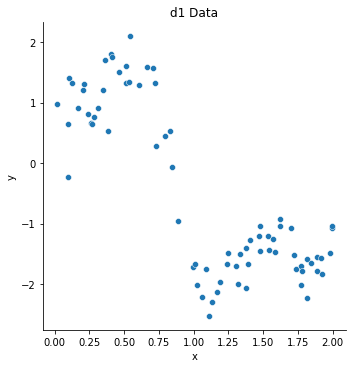

In [8]:
# d1 scatterplot
sns.relplot(
    data = d1,
    x = "x",
    y = "y",
).set(
    title = "d1 Data"
)

plt.show()

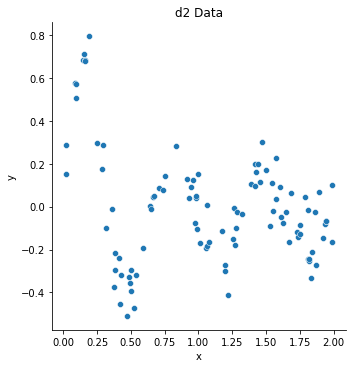

In [9]:
# d2 scatterplot
sns.relplot(
    data = d2,
    x = "x",
    y = "y",
).set(
    title = "d2 Data"
)
plt.show()

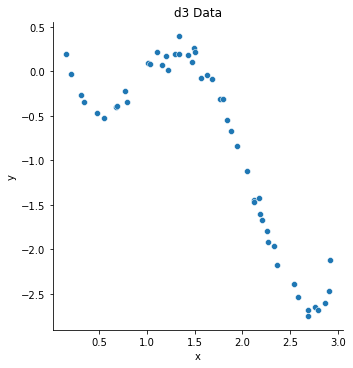

In [10]:
# d3 scatterplot
sns.relplot(
    data = d3,
    x = "x",
    y = "y",
).set(
    title = "d3 Data"
)
plt.show()

In [11]:
def plot_gp(pred, d = None):
    # Manipulate data frame to include mean and bounds of 95% confidence interval
    visual_df = pred.melt(id_vars = ["x"]).groupby(["x"]).agg(
         mean = ("value", np.mean), 
         CI_lb = ("value", lambda x: np.quantile(x, .025)),
         CI_ub = ("value", lambda x: np.quantile(x, .975))).reset_index()
    
    plt.figure()
    
    # Plot the mean and confidence interval bounds
    sns.lineplot(
        data = visual_df,
        x = "x",
        y = "CI_ub",
        linestyle = "--",
        color = "red"
    )
    
    sns.lineplot(
        data = visual_df,
        x = "x",
        y = "mean"
    )
    
    sns.lineplot(
        data = visual_df,
        x = "x",
        y = "CI_lb",
        linestyle = "--",
        color = "red"
    ).set(
        title = "Prediction Data",
        xlabel = "x",
        ylabel = "y"
    )
    
    # Give user option to overlay original data
    if d is not None:
        sns.scatterplot(
            data = d,
            x = "x",
            y = "y",
            color = "black"
    )
    
    plt.legend(title='Legend', labels=['97.5% Bound', 'mean', '2.5% Bound'], bbox_to_anchor=(1.4, .65))
        
    plt.show()
    
    pass

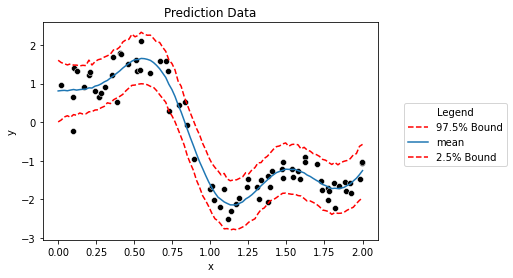

In [12]:
plot_gp(pred1, d1)

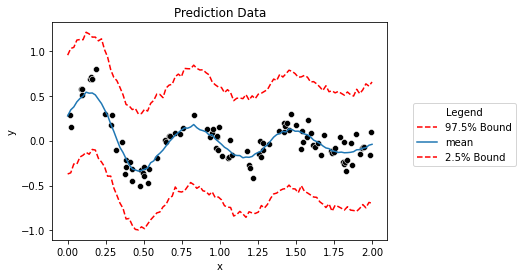

In [13]:
plot_gp(pred2, d2)

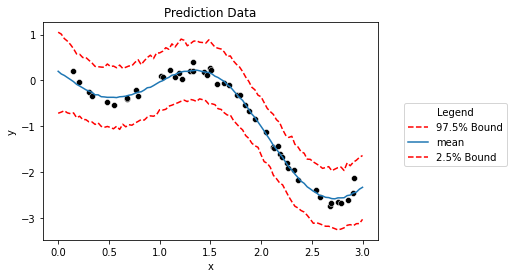

In [14]:
plot_gp(pred3, d3)